In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images for PCA
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [2]:
# Apply PCA for dimensionality reduction
n_components = 100  # Number of principal components to keep
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [3]:
# Reconstruct the images from the reduced representations
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_reconstructed = pca.inverse_transform(x_test_pca)

# Reshape the reconstructed images to original dimensions
x_train_reconstructed = x_train_reconstructed.reshape(x_train.shape)
x_test_reconstructed = x_test_reconstructed.reshape(x_test.shape)

In [7]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Initialize lists for MSE and SSIM values
mse_list = []
ssim_list = []

# Evaluate MSE and SSIM on the first 10 test images
for i in range(10):
    original = x_test[i]  # Original image
    reconstructed = x_test_reconstructed[i]  # Reconstructed image

    # Calculate MSE
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    mse_list.append(mse)

    # Calculate SSIM with data_range specified
    ssim_index = ssim(original, reconstructed, channel_axis=-1, data_range=1.0, win_size=7)
    ssim_list.append(ssim_index)

# Print the average MSE and SSIM
print(f"Average MSE: {np.mean(mse_list)}")
print(f"Average SSIM: {np.mean(ssim_list)}")


Average MSE: 0.0060479952953755856
Average SSIM: 0.7257419228553772


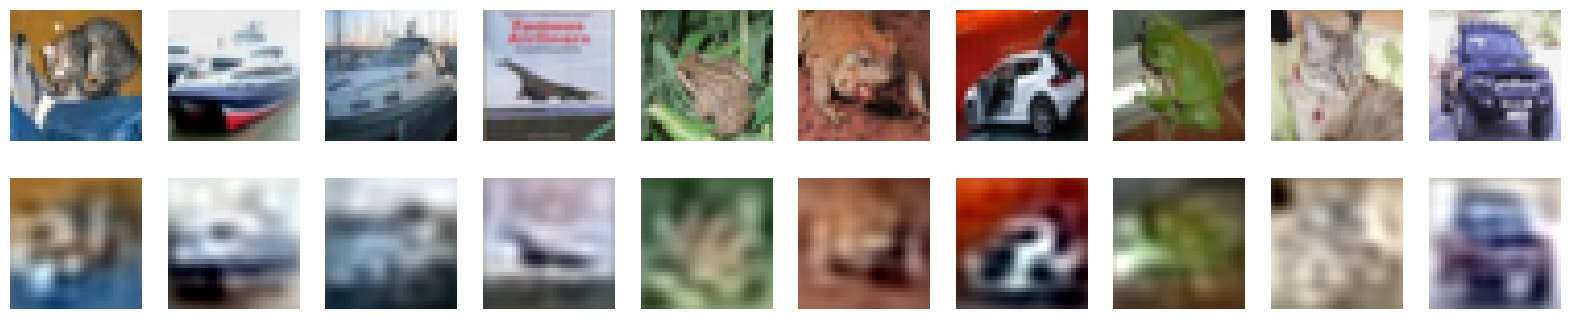

In [8]:
# Visualize the original and reconstructed images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        ax.axis('off')

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        ax.axis('off')
    plt.show()

# Plot some sample images
plot_images(x_test, x_test_reconstructed)

In [10]:
# Calculate the compression ratio
original_size = x_train_flat.shape[1]  # 32x32x3 = 3072 per image
reduced_size = n_components  # Number of principal components used
compression_ratio = reduced_size / original_size
print(f"Compression Ratio: {compression_ratio:.4f}")



Compression Ratio: 0.0326


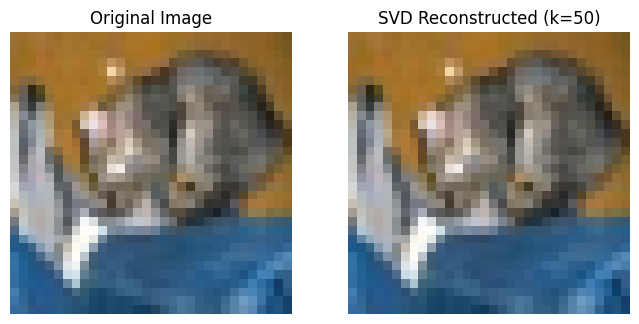

In [12]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

# Function to apply SVD on an image
def apply_svd(image, k):
    # Flatten the image by reshaping the color channels individually
    u_r, s_r, v_r = randomized_svd(image[:, :, 0], n_components=k)
    u_g, s_g, v_g = randomized_svd(image[:, :, 1], n_components=k)
    u_b, s_b, v_b = randomized_svd(image[:, :, 2], n_components=k)

    # Reconstruct each color channel using k singular values
    reconst_r = np.dot(u_r, np.dot(np.diag(s_r), v_r))
    reconst_g = np.dot(u_g, np.dot(np.diag(s_g), v_g))
    reconst_b = np.dot(u_b, np.dot(np.diag(s_b), v_b))

    # Stack the channels back into an image
    reconstructed_image = np.stack([reconst_r, reconst_g, reconst_b], axis=2)

    return np.clip(reconstructed_image, 0, 1)

# Example: Apply SVD on the first test image with k=50
k = 50  # Number of singular values to retain
original_image = x_test[0]
reconstructed_image_svd = apply_svd(original_image, k)

# Visualize the original and SVD-reconstructed image
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# SVD Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_svd)
plt.title(f"SVD Reconstructed (k={k})")
plt.axis('off')

plt.show()


In [14]:
# Function to apply PCA (assuming you already have PCA code from previous steps)
def apply_pca(pca_model, image):
    # Flatten image and apply PCA
    image_flat = image.reshape(-1, 3)
    transformed = pca_model.transform(image_flat)
    reconstructed_flat = pca_model.inverse_transform(transformed)
    return reconstructed_flat.reshape(image.shape)

# Compare SVD and PCA for multiple images
k_svd = 50  # Number of singular values for SVD
n_components_pca = 100  # Number of principal components for PCA

# Initialize lists to store MSE and SSIM results
mse_svd_list = []
ssim_svd_list = []
mse_pca_list = []
ssim_pca_list = []

# Iterate over the first 10 images in the test set
for i in range(10):
    original_image = x_test[i]

    # Apply SVD
    reconstructed_svd = apply_svd(original_image, k_svd)

    # Apply PCA (assumes PCA model is already trained as described before)
    reconstructed_pca = apply_pca(pca, original_image)

    # Calculate MSE for SVD
    mse_svd = mean_squared_error(original_image.flatten(), reconstructed_svd.flatten())
    mse_svd_list.append(mse_svd)

    # Calculate SSIM for SVD
    ssim_svd_index = ssim(original_image, reconstructed_svd, channel_axis=-1, data_range=1.0, win_size=7)
    ssim_svd_list.append(ssim_svd_index)

    # Calculate MSE for PCA
    mse_pca = mean_squared_error(original_image.flatten(), reconstructed_pca.flatten())
    mse_pca_list.append(mse_pca)

    # Calculate SSIM for PCA
    ssim_pca_index = ssim(original_image, reconstructed_pca, channel_axis=-1, data_range=1.0, win_size=7)
    ssim_pca_list.append(ssim_pca_index)

# Print average MSE and SSIM for SVD and PCA
print(f"Average MSE (SVD): {np.mean(mse_svd_list)}")
print(f"Average SSIM (SVD): {np.mean(ssim_svd_list)}")
print(f"Average MSE (PCA): {np.mean(mse_pca_list)}")
print(f"Average SSIM (PCA): {np.mean(ssim_pca_list)}")


ValueError: X has 3 features, but PCA is expecting 3072 features as input.